In [1]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton

In [2]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.0

ntrain = 6
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
ytrain = ftrain + noise_train*(np.random.rand(ntrain, 1) - 0.5)

In [3]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]**2*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 20
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean
 

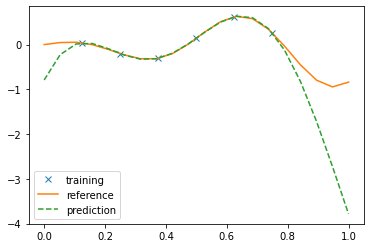

In [4]:
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

In [19]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 0.3, 50)
nlls = np.array(
    [nll([l, 1e-6], xtrain, ytrain, build_K=build_K) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

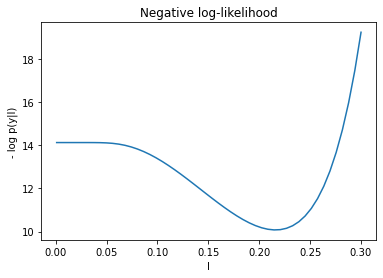

In [24]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')